In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [24]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [25]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
           tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis = -1),
                                  input_shape = [None]),
           tf.keras.layers.SimpleRNN(20, return_sequences = True),
           tf.keras.layers.SimpleRNN(10),
           tf.keras.layers.Dense(1),
           tf.keras.layers.Lambda(lambda x: x*100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 10**-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = .9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])

history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
31/31 [==============================] - 2s 79ms/step - loss: 148.5348 - mae: 149.0417
Epoch 2/100
31/31 [==============================] - 1s 19ms/step - loss: 147.4589 - mae: 147.9719
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 146.0912 - mae: 146.7215
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 144.7232 - mae: 145.3849
Epoch 5/100
31/31 [==============================] - 1s 19ms/step - loss: 143.4708 - mae: 143.9780
Epoch 6/100
31/31 [==============================] - 1s 19ms/step - loss: 142.0619 - mae: 142.5106
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 140.5021 - mae: 140.9892
Epoch 8/100
31/31 [==============================] - 1s 19ms/step - loss: 138.7254 - mae: 139.4087
Epoch 9/100
31/31 [==============================] - 1s 19ms/step - loss: 137.4888 - mae: 137.7546
Epoch 10/100
31/31 [==============================] - 1s 19ms/step - loss: 135.6670 - mae: 136.0061
Epoch 11/

31/31 [==============================] - 1s 20ms/step - loss: 13.6764 - mae: 14.0483
Epoch 85/100
31/31 [==============================] - 1s 20ms/step - loss: 10.8492 - mae: 11.4946
Epoch 86/100
31/31 [==============================] - 1s 20ms/step - loss: 16.1393 - mae: 16.6110
Epoch 87/100
31/31 [==============================] - 1s 19ms/step - loss: 15.8084 - mae: 16.3289
Epoch 88/100
31/31 [==============================] - 1s 19ms/step - loss: 15.6475 - mae: 16.1001
Epoch 89/100
31/31 [==============================] - 1s 19ms/step - loss: 15.3211 - mae: 15.8022
Epoch 90/100
31/31 [==============================] - 1s 20ms/step - loss: 15.6605 - mae: 16.1935
Epoch 91/100
31/31 [==============================] - 1s 19ms/step - loss: 16.6851 - mae: 17.2543
Epoch 92/100
31/31 [==============================] - 1s 19ms/step - loss: 16.0668 - mae: 16.5907
Epoch 93/100
31/31 [==============================] - 1s 19ms/step - loss: 16.2492 - mae: 16.8119
Epoch 94/100
31/31 [=============

In [26]:
history.history['lr']
plt.semilogx(history.history['lr'], history.history['loss'])

KeyError: 'lr'

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
           tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis = -1),
                                  input_shape = [None]),
           tf.keras.layers.SimpleRNN(20, return_sequences = True),
           tf.keras.layers.SimpleRNN(10),
           tf.keras.layers.Dense(1),
           tf.keras.layers.Lambda(lambda x: x*100)
])

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 10**-8 * 10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(lr = 3e-6, momentum = .9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])

history = model.fit(train_set, epochs = 100)

Epoch 1/100
31/31 [==============================] - 2s 71ms/step - loss: 95.1407 - mae: 96.4238
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 17.7705 - mae: 18.1892
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 15.9752 - mae: 16.4418
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 15.6254 - mae: 16.1774
Epoch 5/100
31/31 [==============================] - 1s 20ms/step - loss: 15.6502 - mae: 16.0894
Epoch 6/100
31/31 [==============================] - 1s 20ms/step - loss: 15.5223 - mae: 15.9567
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 15.3244 - mae: 15.7702
Epoch 8/100
31/31 [==============================] - 1s 19ms/step - loss: 15.0306 - mae: 15.5356
Epoch 9/100
31/31 [==============================] - 1s 20ms/step - loss: 14.7056 - mae: 15.1472
Epoch 10/100
31/31 [==============================] - 1s 19ms/step - loss: 13.6666 - mae: 14.1177
Epoch 11/100
31/31 [=========

31/31 [==============================] - 1s 19ms/step - loss: 6.3461 - mae: 6.8179
Epoch 87/100
31/31 [==============================] - 1s 19ms/step - loss: 5.9831 - mae: 6.4775
Epoch 88/100
31/31 [==============================] - 1s 19ms/step - loss: 5.8318 - mae: 6.2946
Epoch 89/100
31/31 [==============================] - 1s 19ms/step - loss: 5.3972 - mae: 5.9023
Epoch 90/100
31/31 [==============================] - 1s 19ms/step - loss: 5.6277 - mae: 6.1176
Epoch 91/100
31/31 [==============================] - 1s 19ms/step - loss: 5.7485 - mae: 6.2861
Epoch 92/100
31/31 [==============================] - 1s 19ms/step - loss: 5.8533 - mae: 6.3152
Epoch 93/100
31/31 [==============================] - 1s 19ms/step - loss: 5.7741 - mae: 6.2828
Epoch 94/100
31/31 [==============================] - 1s 19ms/step - loss: 5.7838 - mae: 6.2735
Epoch 95/100
31/31 [==============================] - 1s 19ms/step - loss: 5.9727 - mae: 6.4803
Epoch 96/100
31/31 [==============================] -

[array([[42.92102]], dtype=float32), array([[52.251156]], dtype=float32), array([[49.55231]], dtype=float32), array([[48.564453]], dtype=float32), array([[43.428127]], dtype=float32), array([[44.78927]], dtype=float32), array([[47.56904]], dtype=float32), array([[43.30644]], dtype=float32), array([[47.10806]], dtype=float32), array([[45.340843]], dtype=float32), array([[45.080364]], dtype=float32), array([[43.849533]], dtype=float32), array([[51.940453]], dtype=float32), array([[48.08068]], dtype=float32), array([[42.00966]], dtype=float32), array([[47.258713]], dtype=float32), array([[41.688316]], dtype=float32), array([[43.762745]], dtype=float32), array([[37.031395]], dtype=float32), array([[36.495407]], dtype=float32), array([[42.15852]], dtype=float32), array([[45.380825]], dtype=float32), array([[43.60925]], dtype=float32), array([[41.900528]], dtype=float32), array([[40.731525]], dtype=float32), array([[35.650974]], dtype=float32), array([[36.214478]], dtype=float32), array([[37

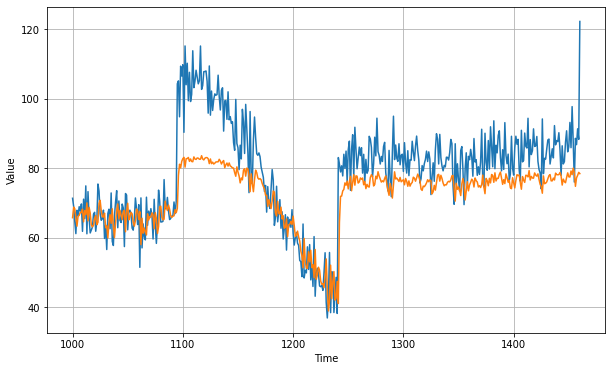

In [49]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

print(forecast)
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [50]:
epochs = history.history['epochs']

KeyError: 'epochs'

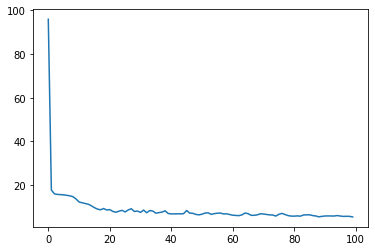

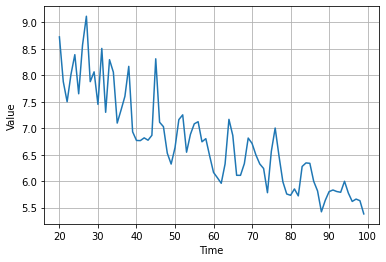

In [59]:
loss = history.history['loss']
epochs = range(len(loss))
mae = history.history['mae']
plt.plot(epochs, loss)
plt.show()
plot_series(epochs, loss, start = 20, end = 100)

In [61]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

8.236864